In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import keras
from IPython.display import Image, display
from tensorflow.python.framework import ops
from numpy import random
from keras.models import Model


!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login
from wandb.keras import WandbCallback

     |████████████████████████████████| 2.1MB 6.7MB/s 
     |████████████████████████████████| 163kB 25.8MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 133kB 21.9MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
PROJECT_NAME = "CS6910 ASSIGNMENT 2"
cls={'Amphibia':0,
     'Animalia':1,
     'Arachnida':2,
     'Aves':3,
     'Fungi':4,
     'Insecta':5,
     'Mammalia':6,
     'Mollusca':7,
     'Plantae':8,
     'Reptilia':9}

inv_cls = {v: k for k, v in cls.items()}

In [15]:
from tensorflow.keras.preprocessing import image

run = wandb.init(project=PROJECT_NAME, job_type="inference")
# use the latest version of the model
model_at = run.use_artifact('cs6910krsrd/CS6910 ASSIGNMENT 2/CNN:v8', type='model')
# rohithd/uncategorized/CNN:v0', type='model'
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model = tf.keras.models.load_model(model_dir)

test_data_at = run.use_artifact('krsrinivas/CS6910 ASSIGNMENT 2/test_raw_data_2000:v0', type='raw_data')
test_dir = test_data_at.download()


imgs = []
true_pred=[]
class_labels = os.listdir(test_dir)
for l in class_labels:
  if l.startswith("."):
    continue
  imgs_per_class = os.listdir(os.path.join(test_dir, l))
  for img in imgs_per_class:
    img_path = os.path.join(test_dir, l, img)
    if img_path[-4:]!=".jpg":
      continue
    img = image.load_img(img_path, target_size=(229, 229))
    img = image.img_to_array(img)
    # don't forget to rescale test images to match the range of inputs
    # to the network
    img = np.expand_dims(img/255.0, axis=0)
    imgs.append(img)
    true_pred.append(cls[l])
imgs = np.vstack(imgs)


preds = {}
classes = model.predict(imgs, batch_size=32)
for c in classes:
  class_id = np.argmax(c)
  if class_id in preds:
    preds[class_id] += 1
  else:
    preds[class_id] = 1

# print the counts of predicted labels as a quick sanity check
# note that for tiny/medium datasets, this won't be very meaningful
print(preds)
run.finish()

model:  ./artifacts/CNN:v8


wandb: Downloading large artifact test_raw_data_2000:v0, 604.34MB. 2000 files... Done. 0:0:0


{2: 198, 3: 152, 6: 288, 4: 313, 8: 250, 0: 117, 1: 174, 9: 314, 5: 130, 7: 64}


In [ ]:
true_pred_vector=np.zeros((np.shape(true_pred)[0],10))
for i,true_val in enumerate(true_pred):
  true_pred_vector[i,true_val]=1
true_pred_vector=np.array(true_pred_vector)

In [ ]:
model.evaluate(imgs,true_pred_vector)

In [ ]:
run = wandb.init(project=PROJECT_NAME, job_type="inference")

fig,axs =plt.subplots(3,10,figsize=(15,6))
axs=axs.reshape(30)

for i in range(30):
  a=np.random.randint(2000)
  classes = model.predict(np.expand_dims(imgs[a], axis=0), batch_size=32)
  axs[i].set_xticks([])
  axs[i].set_yticks([])# plot filter channel in grayscale
  axs[i].imshow(imgs[a])
  axs[i].title.set_text("True:"+ inv_cls[true_pred] + "Pred:" + inv_cls[np.argmax(classes)])

wandb.log({"chartpred": plt})


fig.show()
run.finish()

In [ ]:
run = wandb.init(project=PROJECT_NAME, job_type="inference")

modelConv1=Model(inputs=model.inputs, outputs=model.layers[0].output)

# take a random image "img"
img= np.expand_dims(img, axis=0)
print(np.shape(img))

wandb.log({"image": [wandb.Image(img, caption=" ")]})

preds=modelConv1.predict(img,batch_size=32)
square = 6
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])# plot filter channel in grayscale
		plt.imshow(preds[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
wandb.log({"chart": plt})
plt.show()


run.finish()

In [21]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad
  
def compute_loss(input_image, neuron_index,feature_extractor):
    inputs = tf.cast(input_image, tf.float32)
    activation = feature_extractor(inputs)
    filter_activation = activation[0, :, :, neuron_index]
    return filter_activation

def gradient_ascent_step(img, neuron_index,feature_extractor):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, neuron_index,feature_extractor)
        # Compute gradients.
        grads = tape.gradient(loss, img)
    return loss, grads

def visualize_filter(neuron_index,img,feature_extractor):
    img=np.expand_dims(img, axis=0)
    img=tf.convert_to_tensor(img)

    loss, img = gradient_ascent_step(img, neuron_index,feature_extractor)
    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]
    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [16]:
layer_name="conv2d_4"

layer = model.get_layer(name=layer_name)
feature_extractor = Model(inputs=model.inputs, outputs=layer.output)


layer_dict = [layer for layer in feature_extractor.layers[1:] if hasattr(layer,'activation')]

for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

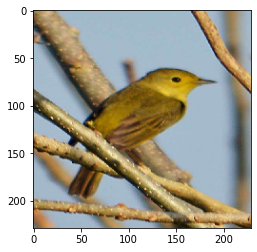

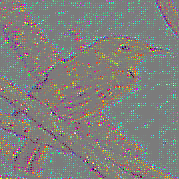

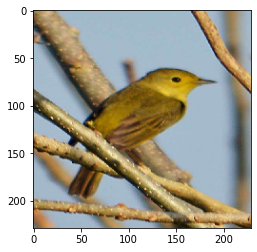

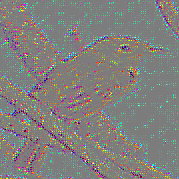

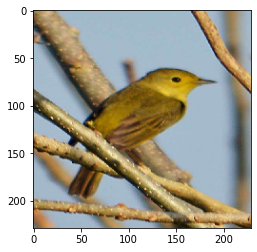

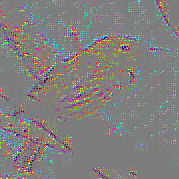

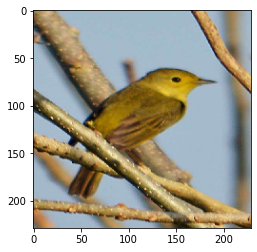

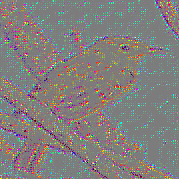

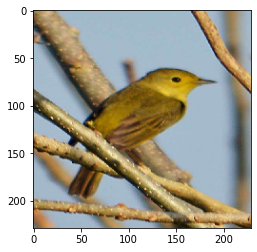

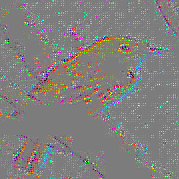

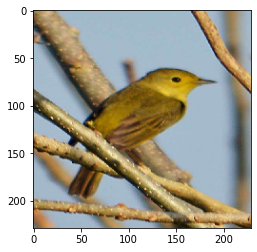

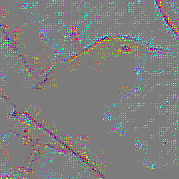

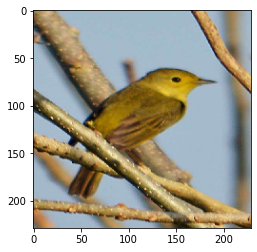

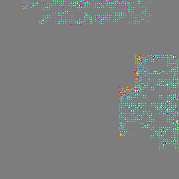

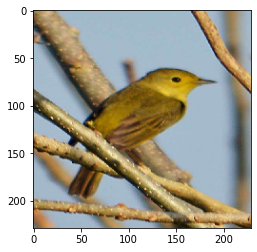

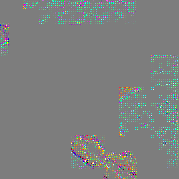

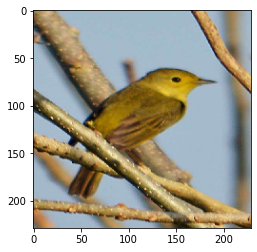

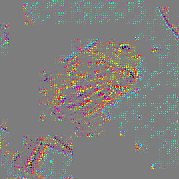

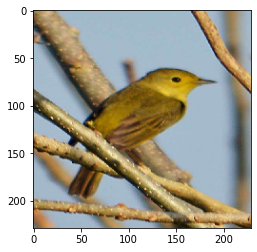

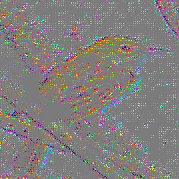

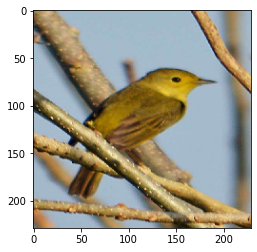

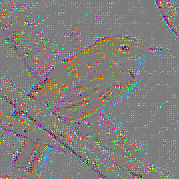

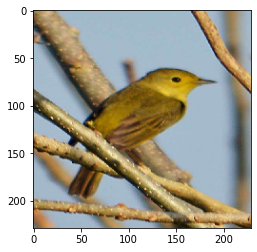

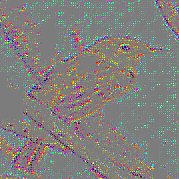

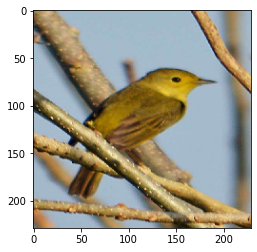

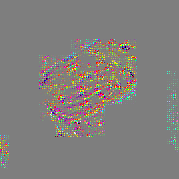

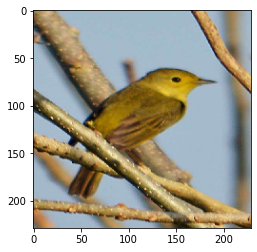

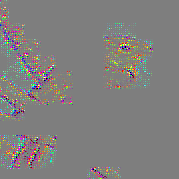

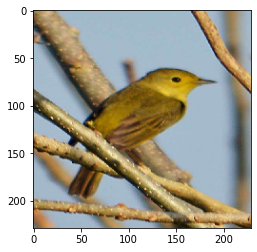

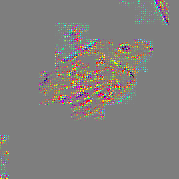

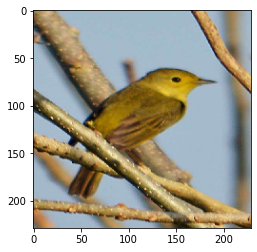

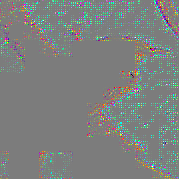

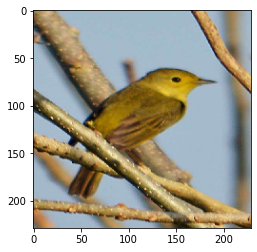

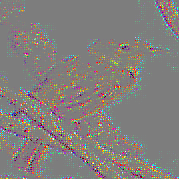

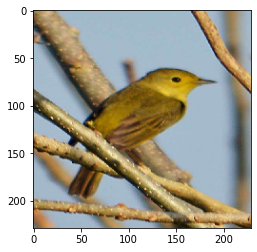

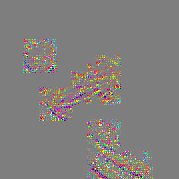

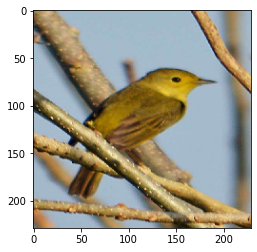

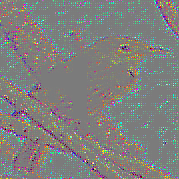

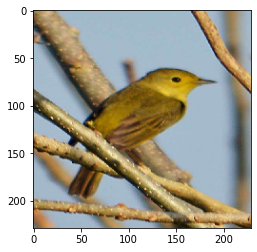

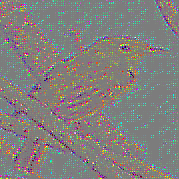

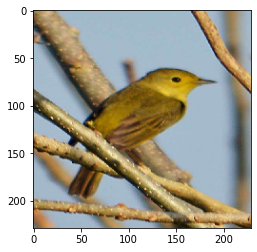

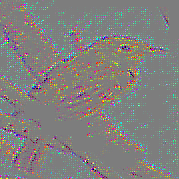

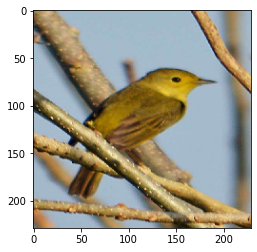

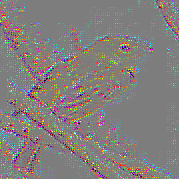

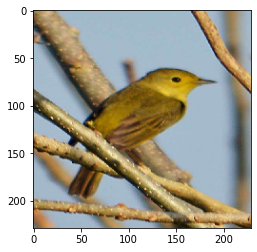

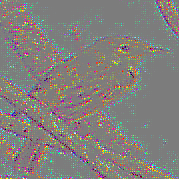

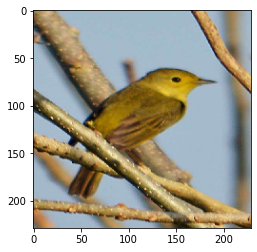

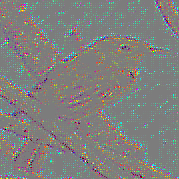

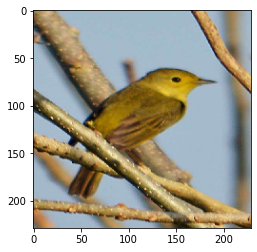

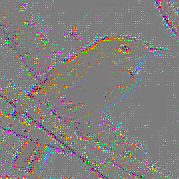

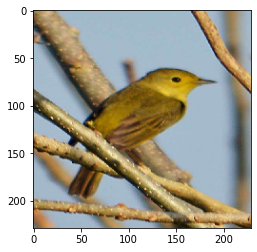

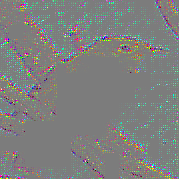

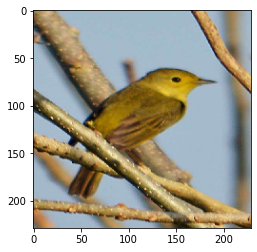

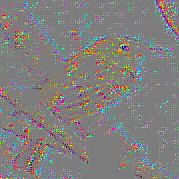

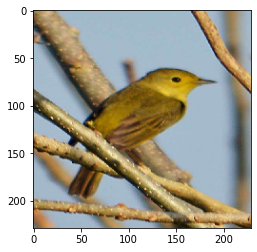

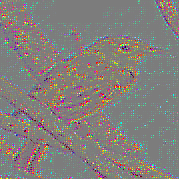

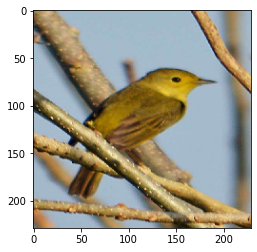

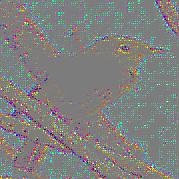

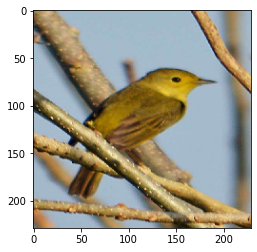

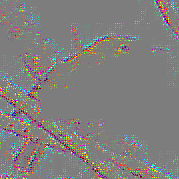

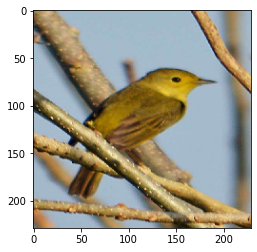

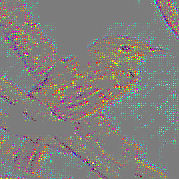

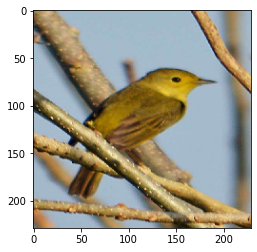

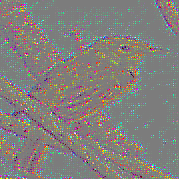

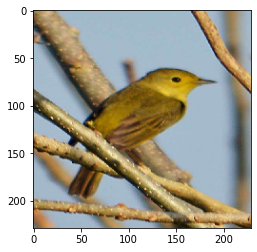

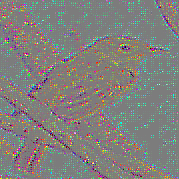

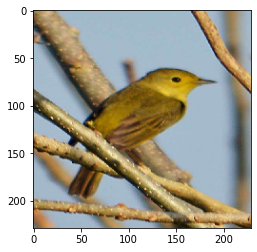

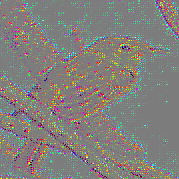

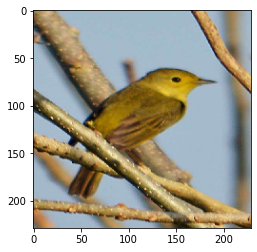

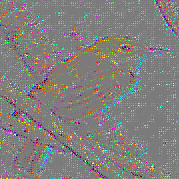

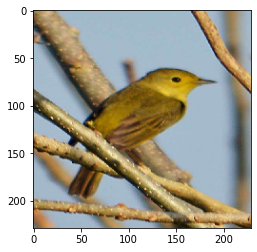

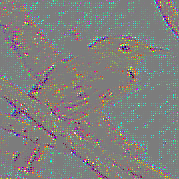

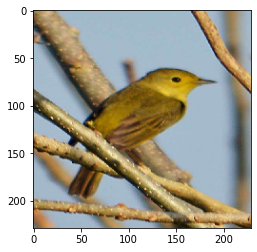

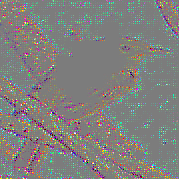

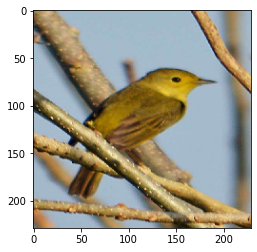

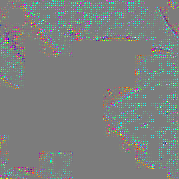

KeyboardInterrupt: ignored

In [34]:
run = wandb.init(project=PROJECT_NAME, job_type="inference")

img_width,img_height=229,229

a=899 
plt.imshow(imgs[a])
plt.show()
wandb.log({"original Image": [wandb.Image(imgs[a], caption="Image")]})

for i in range(100):  

  loss, img_guid = visualize_filter(i,imgs[a],feature_extractor)
  wandb.log({"guided backprop": [wandb.Image(img_guid, caption=str(i))]})
  keras.preprocessing.image.save_img("0.png", img_guid)
  display(Image("0.png"))


run.finish()